<a href="https://colab.research.google.com/github/thomaslu678/gee-test/blob/main/clean/8_basic_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTE: Requires export_clean.csv (cleaned up export CSV with sorts and time columns)

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from datetime import timedelta
import scipy.stats as stats
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
import geopandas as gpd
from shapely.geometry import Point
import requests

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import shap

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Year 2/Fall 2025/HONOR 3700/Data/2/dataset.csv')

In [24]:
df

,NDVI,NDBI,NDMI,Albedo,time_years,long,lat,distance,hour_of_day,month,m
0,0.008107,-0.042450,0.042450,0.185196,18.979367,127.013452,37.572606,317.553292,1,12,-0.029627
1,0.008107,-0.105622,0.105622,0.183640,18.979367,127.013792,37.572608,317.478476,1,12,-0.003934
2,-0.011292,-0.099890,0.099890,0.176036,18.979367,127.013794,37.572337,287.478569,1,12,-0.007349
3,-0.029073,-0.068238,0.068238,0.171996,18.979367,127.014133,37.572339,287.403753,1,12,-0.007378
4,0.008107,-0.092413,0.092413,0.181680,18.979367,127.014135,37.572068,257.403847,1,12,-0.019299
...,...,...,...,...,...,...,...,...,...,...,...
2646549,0.192808,0.070690,-0.070690,0.085628,56.083537,127.044375,37.571377,285.926939,2,1,-0.037815
2646550,0.306176,0.073418,-0.073418,0.127741,56.083537,127.044377,37.571107,294.332867,2,1,-0.026298
2646551,0.157747,-0.135409,0.135409,0.149991,56.083537,127.044379,37.570837,305.465969,2,1,-0.020183
2646552,0.157339,0.031072,-0.031072,0.071202,56.083537,127.044715,37.571379,315.186207,2,1,-0.031023


# Prep ML

In [8]:
TARGET = 'm'
FEATURES = [c for c in df.columns if c != TARGET]

X = df[FEATURES].values.astype(np.float32)
y = df[TARGET].values.astype(np.float32).reshape(-1, 1)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42
)

In [10]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [11]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
BATCH_SIZE = 8192  # tune based on GPU/CPU memory

train_ds = TabularDataset(X_train, y_train)
val_ds = TabularDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [14]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_dim=X_train.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
EPOCHS = 1  # increase if needed

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    preds_list = []
    y_list = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss += criterion(preds, yb).item() * xb.size(0)

            preds_list.append(preds.cpu().numpy())
            y_list.append(yb.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    y_val_pred = np.vstack(preds_list)
    y_val_true = np.vstack(y_list)

    r2 = r2_score(y_val_true, y_val_pred)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train MSE: {train_loss:.4f} | "
          f"Val MSE: {val_loss:.4f} | "
          f"R2: {r2:.4f}")

Epoch 1/1 | Train MSE: 0.0122 | Val MSE: 0.0030 | R2: -0.3300


In [19]:
# Sample for SHAP (adjust sizes if needed)
BACKGROUND_SIZE = 2000
EXPLAIN_SIZE = 5000

background_idx = np.random.choice(len(X_train), BACKGROUND_SIZE, replace=False)
explain_idx = np.random.choice(len(X_val), EXPLAIN_SIZE, replace=False)

X_background = torch.from_numpy(X_train[background_idx]).to(device)
X_explain = torch.from_numpy(X_val[explain_idx]).to(device)

In [20]:
model.eval()

explainer = shap.DeepExplainer(model, X_background)
shap_values = explainer.shap_values(X_explain)


In [25]:
shap_values.shape

(5000, 10, 1)

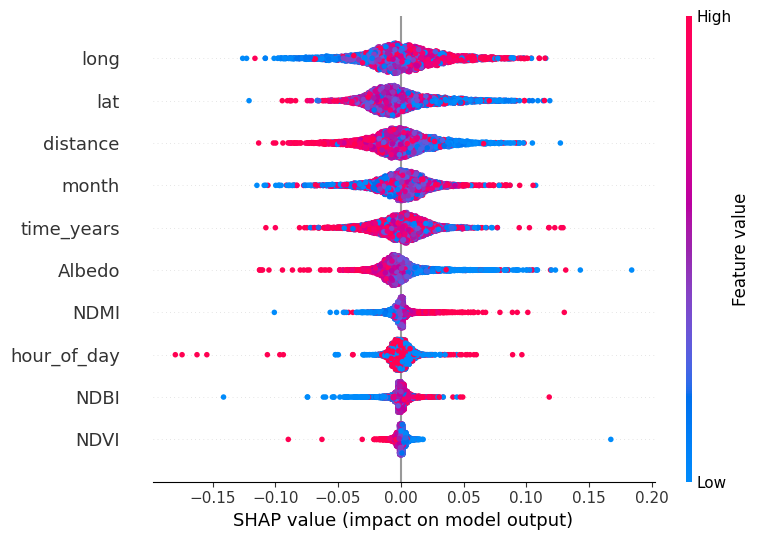

In [32]:
# Remove the last dimension
shap_vals = shap_values[0] if isinstance(shap_values, list) else shap_values
shap_vals = np.squeeze(shap_vals)  # shape: (5000, 10)

# Now plot
shap.summary_plot(
    shap_vals,
    X_val[explain_idx],
    feature_names=FEATURES,
    show=True
)

In [30]:
print("SHAP values shape:", shap_vals.shape)  # should be (5000, 10)

SHAP values shape: (5000, 10)
